In [1]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# Load the pre-trained VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [5]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add fully connected layers
x = Dense(1024, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
!unzip "/content/Histo_dataset.zip"

Archive:  /content/Histo_dataset.zip
   creating: Histo_dataset/
   creating: Histo_dataset/DiabeticSmallIntestine/
   creating: Histo_dataset/normalliver/
   creating: Histo_dataset/DiabeticLiver/
  inflating: Histo_dataset/.DS_Store  
  inflating: __MACOSX/Histo_dataset/._.DS_Store  
   creating: Histo_dataset/DiabeticSmallIntestineAelovera/
   creating: Histo_dataset/NormalPancreas/
   creating: Histo_dataset/DiabeticPancreas/
   creating: Histo_dataset/NormalSmallIntestine/
   creating: Histo_dataset/DiabeticAeloveraLiver/
   creating: Histo_dataset/DiabeticAeloveraPancreas/
  inflating: Histo_dataset/DiabeticSmallIntestine/Screenshot 2023-11-20 at 4.36.11 PM.png  
  inflating: __MACOSX/Histo_dataset/DiabeticSmallIntestine/._Screenshot 2023-11-20 at 4.36.11 PM.png  
  inflating: Histo_dataset/DiabeticSmallIntestine/Screenshot 2023-11-20 at 4.36.21 PM.png  
  inflating: __MACOSX/Histo_dataset/DiabeticSmallIntestine/._Screenshot 2023-11-20 at 4.36.21 PM.png  
  inflating: Histo_datas

In [11]:
import os

def remove_ds_store(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed: {file_path}")

In [12]:
remove_ds_store("/content/Histo_dataset")

Removed: /content/Histo_dataset/.DS_Store
Removed: /content/Histo_dataset/DiabeticPancreas/.DS_Store
Removed: /content/Histo_dataset/NormalPancreas/.DS_Store


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Specify your data directory
train_generator = train_datagen.flow_from_directory(
    '/content/Histo_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 34 images belonging to 9 classes.


In [17]:
model.fit(
    train_generator,
    epochs=100,  # Adjust the number of epochs based on your dataset size and training performance
    steps_per_epoch=len(train_generator),
    verbose=1
)

Epoch 1/100
2/2 [==============================] - 1s 56ms/step - loss: 1.3181 - accuracy: 0.3824
Epoch 2/100
2/2 [==============================] - 1s 859ms/step - loss: 1.4172 - accuracy: 0.4412
Epoch 3/100
2/2 [==============================] - 1s 1s/step - loss: 1.4971 - accuracy: 0.4412
Epoch 4/100
2/2 [==============================] - 1s 61ms/step - loss: 1.2540 - accuracy: 0.4706
Epoch 5/100
2/2 [==============================] - 1s 57ms/step - loss: 1.2102 - accuracy: 0.3824
Epoch 6/100
2/2 [==============================] - 1s 57ms/step - loss: 1.2551 - accuracy: 0.4118
Epoch 7/100
2/2 [==============================] - 1s 57ms/step - loss: 1.0810 - accuracy: 0.5882
Epoch 8/100
2/2 [==============================] - 1s 799ms/step - loss: 1.2007 - accuracy: 0.4412
Epoch 9/100
2/2 [==============================] - 1s 58ms/step - loss: 1.1926 - accuracy: 0.5000
Epoch 10/100
2/2 [==============================] - 1s 802ms/step - loss: 1.3253 - accuracy: 0.4118
Epoch 11/100
2/2 [

In [18]:
model.save_weights('/content/sample_data/weights.h5')

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/Histo_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: Set shuffle to False for the test generator
)

Found 34 images belonging to 9 classes.


In [21]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

2/2 [==============================] - 1s 29ms/step - loss: 0.8064 - accuracy: 0.6765
Test loss: 0.8064
Test accuracy: 0.6765


1/1 [==============================] - 0s 39ms/step


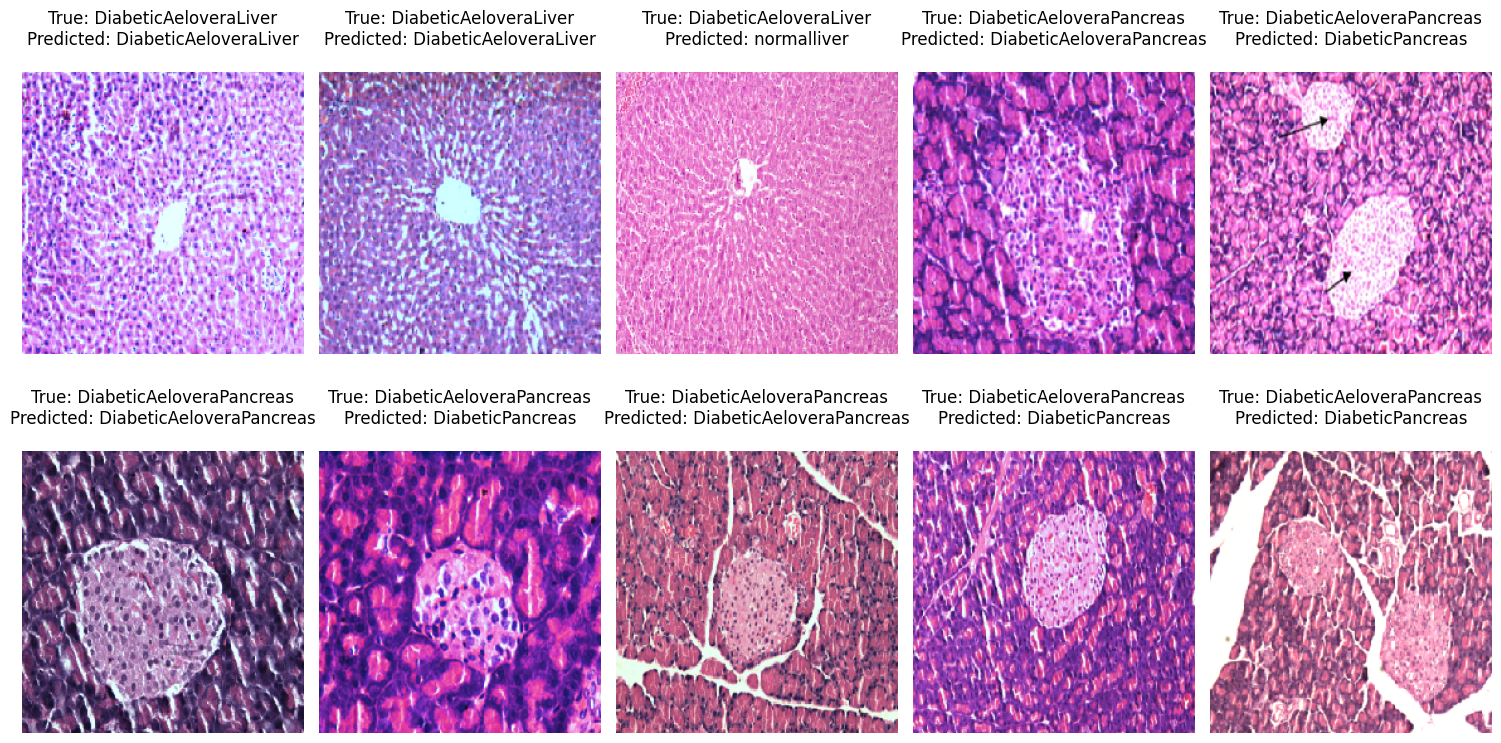

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Function to plot images with their predictions
def plot_images_with_predictions(model, generator, num_samples=10):
    # Get the class labels
    class_labels = list(generator.class_indices.keys())

    # Get a batch of images and their true labels from the generator
    images, true_labels = generator.next()

    # Make predictions using the model
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Ensure num_samples does not exceed the number of available samples
    num_samples = min(num_samples, len(images))

    # Plot the images along with their true and predicted labels
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])

        # Convert true_labels[i] and predicted_labels[i] to integer
        true_label_index = np.argmax(true_labels[i])
        predicted_label_index = predicted_labels[i]

        plt.title(f'True: {class_labels[true_label_index]}\nPredicted: {class_labels[predicted_label_index]}', pad=20)  # Adjust 'pad' for spacing
        plt.axis('off')

    plt.tight_layout(h_pad=2)  # Adjust 'h_pad' for vertical spacing
    plt.show()

# Call the function to plot images with predictions
plot_images_with_predictions(model, test_generator, num_samples=10)
